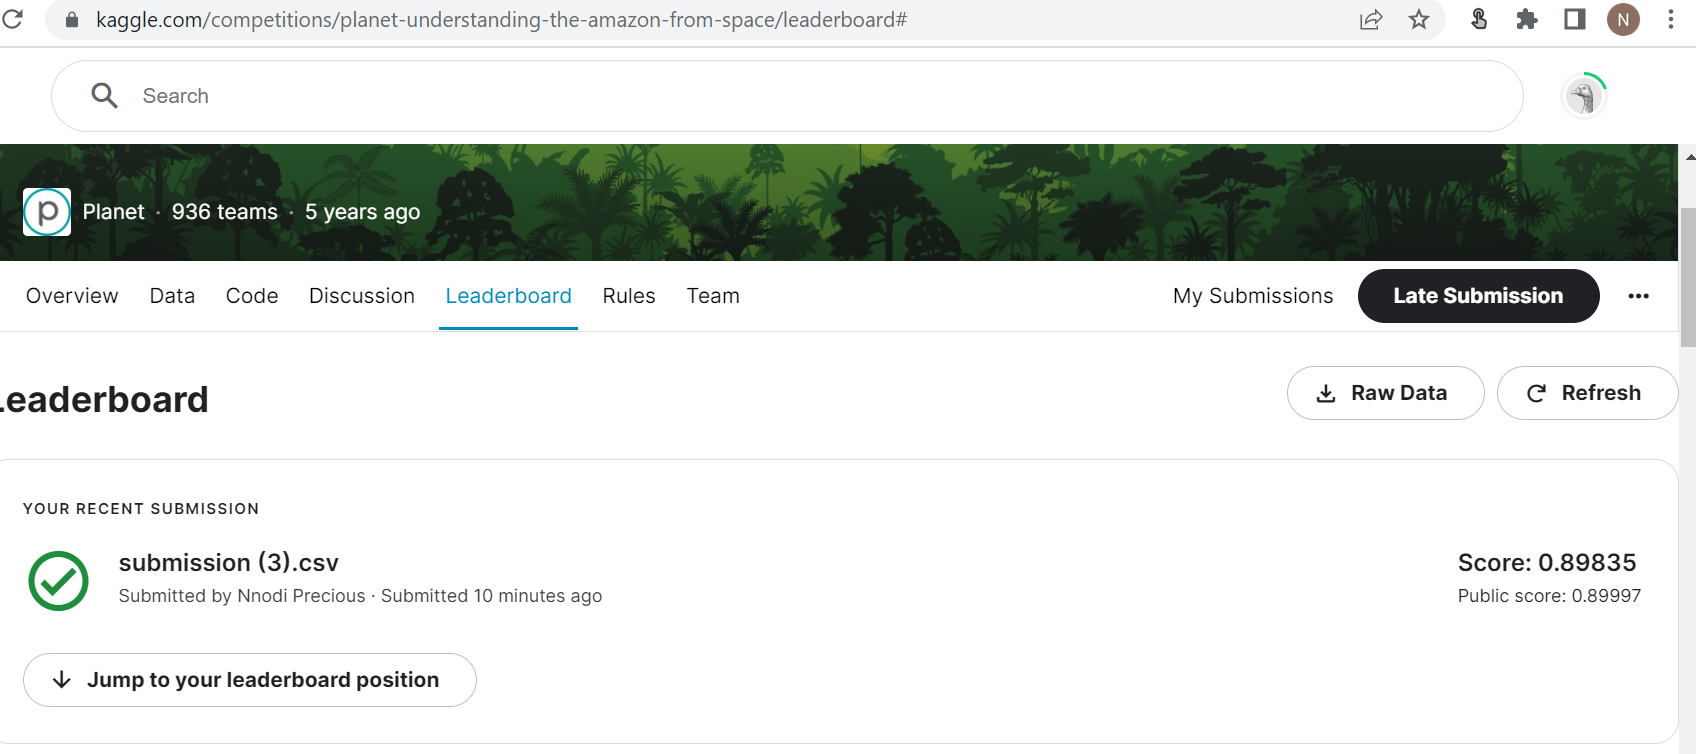

##Above is a screenshot of my score on Kaggle leaderboard.
 - 'Jump to your leaderboard position' was not going through hence I was unable to see my position on the leader board. 

In [1]:
!pip install kaggle 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir  ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d nikitarom/planets-dataset
! mkdir dataset

! unzip planets-dataset.zip -d dataset 

Streaming output truncated to the last 5000 lines.
  inflating: dataset/test-jpg-additional/test-jpg-additional/file_5499.jpg  
  inflating: dataset/test-jpg-additional/test-jpg-additional/file_55.jpg  
  inflating: dataset/test-jpg-additional/test-jpg-additional/file_550.jpg  
  inflating: dataset/test-jpg-additional/test-jpg-additional/file_5500.jpg  
  inflating: dataset/test-jpg-additional/test-jpg-additional/file_5501.jpg  
  inflating: dataset/test-jpg-additional/test-jpg-additional/file_5502.jpg  
  inflating: dataset/test-jpg-additional/test-jpg-additional/file_5503.jpg  
  inflating: dataset/test-jpg-additional/test-jpg-additional/file_5504.jpg  
  inflating: dataset/test-jpg-additional/test-jpg-additional/file_5505.jpg  
  inflating: dataset/test-jpg-additional/test-jpg-additional/file_5506.jpg  
  inflating: dataset/test-jpg-additional/test-jpg-additional/file_5507.jpg  
  inflating: dataset/test-jpg-additional/test-jpg-additional/file_5508.jpg  
  inflating: dataset/test-jp

In [49]:
# Import required libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
import seaborn as sns
import cv2
from glob import glob # handles pathnames 
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from skimage import io
import tifffile

import os 
from os import listdir 
import csv
import gc
import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import cv2
from tqdm import tqdm
from sklearn.metrics import fbeta_score

In [50]:
path = "/content/dataset/planet/planet"
path_train = os.path.join(path, "train-jpg")
path_test = os.path.join(path, "test-jpg")

In [51]:
path_train 

'/content/dataset/planet/planet/train-jpg'

In [80]:
path_class = os.path.join(path, "train_classes.csv")
path_sub = os.path.join(path, "sample_submission.csv")
labels_df = pd.read_csv(path_class)
print(labels_df.shape)
labels_df.head()

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


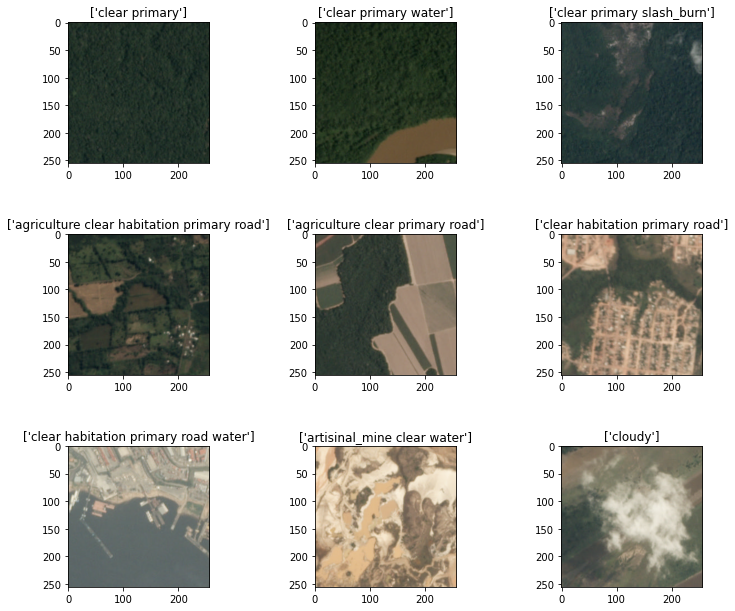

In [53]:
# Pick nine images (jpg)
all_image_paths_jpg = sorted(glob(path_train + "/*.jpg"))
nine_imgs_paths_jpg = []
nine_imgs_paths_jpg.append(all_image_paths_jpg[11006])
nine_imgs_paths_jpg.append(all_image_paths_jpg[15000])
nine_imgs_paths_jpg.append(all_image_paths_jpg[4005])
nine_imgs_paths_jpg.append(all_image_paths_jpg[12007])
nine_imgs_paths_jpg.append(all_image_paths_jpg[8002])
nine_imgs_paths_jpg.append(all_image_paths_jpg[14001])
nine_imgs_paths_jpg.append(all_image_paths_jpg[16004])
nine_imgs_paths_jpg.append(all_image_paths_jpg[13003])
nine_imgs_paths_jpg.append(all_image_paths_jpg[9006])

nine_image_names = list(map(lambda row: row.split('/')[-1][:-4], nine_imgs_paths_jpg))

# Plot them in a 3 by 3 grid
plt.figure(figsize=(12,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)
    plt.imshow(plt.imread(nine_imgs_paths_jpg[i]))
    plt.title(str(labels_df[labels_df.image_name == nine_image_names[i]].tags.values))

In [54]:
# Print shape
print(labels_df.shape)
# How does the training labels file look like?
labels_df.head()
#labels_df.tail()

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [55]:
# Print all unique classes
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") 
                                        for tags in labels_df['tags'].values]))
num_labels = len(labels_list)
uniq_labels = set(labels_list) 
num_uniq_labels = len(uniq_labels) 
print("There are {} labels in the training set".format(num_labels))
print("distributed among {} classes:".format(num_uniq_labels))
print(uniq_labels)

There are 116278 labels in the training set
distributed among 17 classes:
{'partly_cloudy', 'agriculture', 'bare_ground', 'selective_logging', 'blooming', 'road', 'primary', 'slash_burn', 'water', 'conventional_mine', 'haze', 'habitation', 'blow_down', 'clear', 'cloudy', 'artisinal_mine', 'cultivation'}


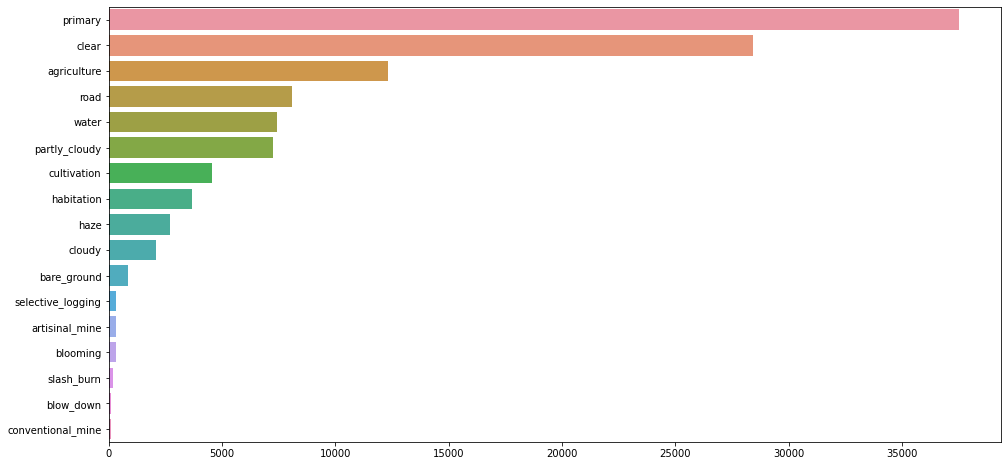

In [56]:
# Histogram of label instances
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')
plt.show()

In [57]:
path2 =path_train + "/*.jpg"

In [58]:
# Subset of images for clustering
n_imgs = 350
clust_imgs = []
image_paths = sorted(glob(path2))[0:n_imgs]

# Image preprocessing
for i in range(n_imgs):
    img = plt.imread(image_paths[i])
    img = cv2.resize(img, (100, 100), cv2.INTER_LINEAR).astype('float')
#    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype('float')
    img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
    img = img.reshape(1, -1)
    clust_imgs.append(img)

# Convert into a Numpy array
img_mat = np.vstack(clust_imgs)
# Number of images, (100pix by 100pix) by 4 bands
img_mat.shape

(350, 40000)

In [59]:
# Fit a t-SNE manifold to the subset of images
tsne = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=2
).fit_transform(img_mat)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 350 samples in 0.010s...
[t-SNE] Computed neighbors for 350 samples in 0.212s...
[t-SNE] Computed conditional probabilities for sample 350 / 350
[t-SNE] Mean sigma: 2.314795
[t-SNE] Computed conditional probabilities in 0.026s
[t-SNE] Iteration 50: error = 71.8496475, gradient norm = 0.4444358 (50 iterations in 0.154s)
[t-SNE] Iteration 100: error = 72.2247925, gradient norm = 0.4441079 (50 iterations in 0.150s)
[t-SNE] Iteration 150: error = 74.2830811, gradient norm = 0.4432163 (50 iterations in 0.125s)
[t-SNE] Iteration 200: error = 77.4948959, gradient norm = 0.4242494 (50 iterations in 0.120s)
[t-SNE] Iteration 250: error = 78.9867401, gradient norm = 0.4163202 (50 iterations in 0.124s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.986740
[t-SNE] Iteration 300: error = 0.9805890, gradient norm = 0.0050446 (50 iterations in 0.127s)
[t-SNE] Iteration 350: error = 0.7815264, gradient norm = 0.0039507 (

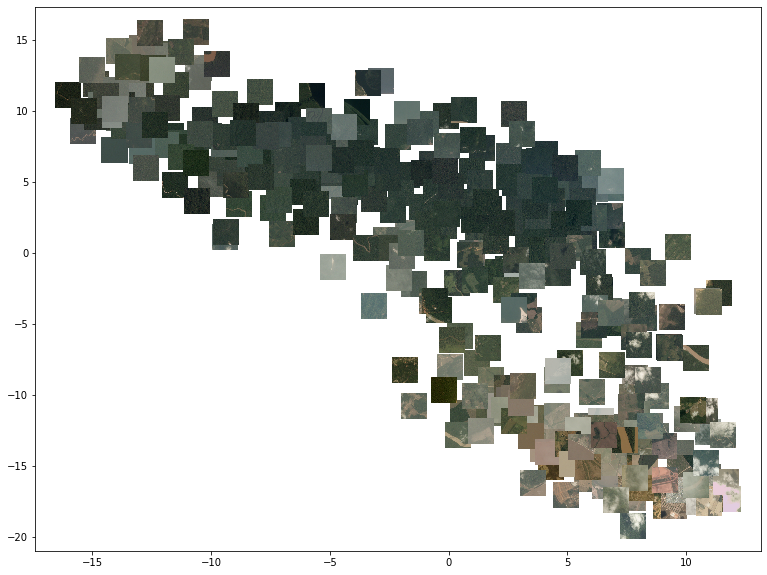

In [60]:
# Plot the subset of images in a two dimensional representation
def imscatter(x, y, images, ax=None, zoom=0.1):
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0 in zip(x, y, images):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

plt.figure(figsize=(13,10))
imscatter(tsne[0:n_imgs,0], tsne[0:n_imgs,1], [plt.imread(image_paths[i]) for i in range(n_imgs)])

In [61]:
# Preprocess labels
x_train = []
x_test = []
y_train = []

df_train = pd.read_csv(path_class)

flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

In [62]:
# Prepare array of images and vector representation of labels
for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.imread('/content/dataset/planet/planet/train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x_train.append(cv2.resize(img, (32,32)))
    y_train.append(targets)

100%|██████████| 40479/40479 [00:56<00:00, 720.37it/s]


In [63]:
# Maximum and minimum values in the array of training images
max_value = np.amax(x_train)
min_value = np.amin(x_train)

print('Min value in the training images array: ', min_value)
print('Max value in the training images array: ', max_value)

Min value in the training images array:  1
Max value in the training images array:  255


In [64]:
# Normalize images into the interval [0,1]
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255.
print("Shape of the training images array is: ")
print(x_train.shape)
print("Shape of the training labels array is: ")
print(y_train.shape)

Shape of the training images array is: 
(40479, 32, 32, 3)
Shape of the training labels array is: 
(40479, 17)


In [65]:
# Split between training and validation sets
split = 35000 # Approx. 86% for training and 14% for validation
x_train, x_valid, y_train, y_valid = (x_train[:split], x_train[split:], 
                                      y_train[:split], y_train[split:])

In [66]:
x_valid.shape

(5479, 32, 32, 3)

In [67]:
model = Sequential()
model.add(BatchNormalization(input_shape=x_train.shape[1:]))
        
model.add(Conv2D(32, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
        
model.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
        
model.add(Conv2D(256, kernel_size=(3, 3),padding='same', activation='relu'))
#model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
        
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

In [68]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 32, 32, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 15, 15, 64)       

In [69]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=12)
es = [EarlyStopping(monitor='val_loss', patience=7, verbose=0)]

In [70]:
import keras
from tensorflow.keras.optimizers import Adam 
opt  = Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

history=model.fit(x = x_train, y= y_train, validation_data=(x_valid, y_valid), batch_size=64,verbose=1, epochs=60,callbacks=es, shuffle=True)

Epoch 1/60
547/547 [==============================] - 7s 10ms/step - loss: 0.2290 - accuracy: 0.4271 - val_loss: 0.1902 - val_accuracy: 0.4579
Epoch 2/60
547/547 [==============================] - 5s 9ms/step - loss: 0.1640 - accuracy: 0.4747 - val_loss: 0.1495 - val_accuracy: 0.5089
Epoch 3/60
547/547 [==============================] - 5s 9ms/step - loss: 0.1549 - accuracy: 0.4481 - val_loss: 0.1499 - val_accuracy: 0.4751
Epoch 4/60
547/547 [==============================] - 5s 10ms/step - loss: 0.1491 - accuracy: 0.4709 - val_loss: 0.1390 - val_accuracy: 0.4844
Epoch 5/60
547/547 [==============================] - 5s 9ms/step - loss: 0.1454 - accuracy: 0.4896 - val_loss: 0.1331 - val_accuracy: 0.4804
Epoch 6/60
547/547 [==============================] - 5s 9ms/step - loss: 0.1416 - accuracy: 0.4967 - val_loss: 0.1311 - val_accuracy: 0.4849
Epoch 7/60
547/547 [==============================] - 5s 9ms/step - loss: 0.1389 - accuracy: 0.5007 - val_loss: 0.1290 - val_accuracy: 0.4990
Epoc

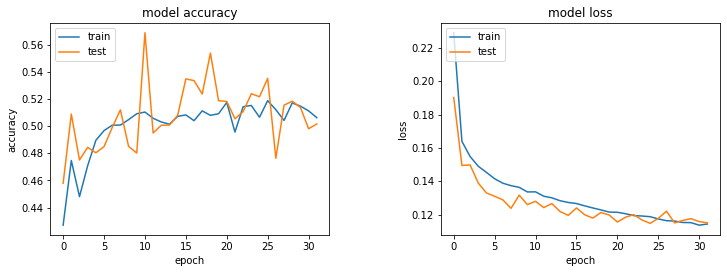

In [71]:
# Plot model accuracy and loss

fig, axs = plt.subplots(1, 2, figsize=(12, 3), sharey=False)
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)

axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'test'], loc='upper left')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'test'], loc='upper left')
plt.show()

In [72]:
# Use the model to predict
p_valid = model.predict(x_valid, batch_size=128)

#np.set_printoptions(precision=2)
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

print("## For a sample of 3 images and the first 5 labels (of 17)\n")
print("True vectorized labels")
print(np.round(y_valid[0:3,0:7]/1.0,2))
print("-------------------------------------------------------")
print("Predicted vectorized labels")
print(np.round(p_valid[0:3,0:7],2))

## For a sample of 3 images and the first 5 labels (of 17)

True vectorized labels
[[ 0.000  0.000  0.000  0.000  0.000  0.000  1.000]
 [ 0.000  1.000  0.000  0.000  0.000  1.000  1.000]
 [ 0.000  1.000  0.000  0.000  0.000  0.000  1.000]]
-------------------------------------------------------
Predicted vectorized labels
[[ 0.000  0.730  0.050  0.020  0.010  0.130  1.000]
 [ 0.000  0.920  0.030  0.000  0.000  0.340  1.000]
 [ 0.000  0.720  0.010  0.010  0.000  0.030  1.000]]


In [73]:
# Print validation accuracy
print(fbeta_score(y_valid, np.array(p_valid) > 0.2, beta=2, average='samples'))

0.9007794612341249


In [83]:
# kaggle submission
X_test = []
submission = []

for file in listdir('/content/dataset/planet/planet/test-jpg'):
    f= file.split('.')[0]


    
    img = cv2.imread('/content/dataset/planet/planet/test-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    
    X_test.append(cv2.resize(img, (32,32)))
    submission.append(f)

for file in listdir('/content/dataset/test-jpg-additional/test-jpg-additional'):
    f2= file.split('.')[0]

    img2 = cv2.imread('/content/dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(f2))
    targets = np.zeros(17)

    X_test.append(cv2.resize(img2, (32,32)))
    submission.append(f2)


X_test = np.array(X_test, np.float16) / 255.

y_test = model.predict(X_test, batch_size=128)


In [84]:
len(y_test )

61191

In [85]:
with open('submission.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(('image_name', 'tags'))
    for i, image in enumerate(submission):
        csv_writer.writerow((image, ' '.join(np.array(labels)[y_test[i] > 0.2])))

In [86]:
df3 = pd.read_csv('submission.csv')
df3.duplicated().sum()

0

In [87]:
df3.shape

(61191, 2)